# House data prediction project

We start with all the imports needed

In [5]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

from threading import Thread
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

Scraper:

The first part of the scraper collects all the advertisments found on a particular site and saves them in a link format

In [ ]:
driver = webdriver.Chrome(keep_alive=True)

options = Options()
options.add_argument('--incognito')

driver.get("https://www.storia.ro/ro/rezultate/vanzare/casa/bucuresti?limit=36&ownerTypeSingleSelect=ALL&by=DEFAULT&direction=DESC&viewType=listing")

def acceptCookies():
    button = driver.find_element(By.ID, "onetrust-accept-btn-handler")
    button.click()

def getLinks():    
    list = []
    nextPageButton = driver.find_element(By.XPATH, "//button[@aria-label='Pagina urmatoare']")
    houseList = driver.find_element(By.XPATH, "//div[@data-cy='search.listing.organic']/ul/li[@data-cy='listing-item']")
    while(nextPageButton.is_enabled()):
        houses = houseList.find_elements(By.XPATH, "//a[@data-cy='listing-item-link']")
        for house in houses:
            link = house.get_attribute("href")
            list.append(link)
        nextPageButton.click()
        houseList = driver.find_element(By.XPATH, "//div[@data-cy='search.listing.organic']/ul/li[@data-cy='listing-item']")
        if(driver.find_element(By.XPATH, "//button[@aria-label='Pagina urmatoare']").is_displayed()):
            nextPageButton = driver.find_element(By.XPATH, "//button[@aria-label='Pagina urmatoare']")
        
    df = pd.DataFrame(list)
    df.to_csv(r"..\CSVs\HouseLinks.csv")

    display(df)

acceptCookies()
getLinks()

driver.close()

The next part opens the links using threads and collects the necessary information for each house

In [ ]:
df = pd.read_csv(r"..\CSVs\HouseLinks.csv")
linkList = df.values.tolist()

HouseDataList = []
 
def openDriver():

    options = Options()
    options.add_argument('--incognito')
    driver = webdriver.Chrome(keep_alive=True, options=options)

    return driver

def scrapeData(link, driver):

    driver.get(link)
    ok = 1
    try:
        table = driver.find_element(By.XPATH, "//div[@data-testid='ad.top-information.table']")
        tableKeys = table.find_elements(By.XPATH, "//div[contains(@data-cy, 'table-label')]")
        tableValues = table.find_elements(By.XPATH, "//div[contains(@data-testid, 'table-value')] | //button[@data-cy='missing-info-button']")

    except Exception as error:
        print(error)
        ok = 0


    if ok == 1:
        houseDetails = {}

        keys = []
        values = []

        for key in tableKeys:
            keys.append(key.get_attribute("innerText"))
        for value in tableValues:
            values.append(value.get_attribute("innerText"))

        for key in keys:
            for value in values:
                houseDetails[key] = value
                values.remove(value)
                break

        price = driver.find_element(By.XPATH, "//strong[@data-cy='adPageHeaderPrice']")

        houseDetails["Pret"] = price.get_attribute("innerText")

        HouseDataList.append(houseDetails)

def threadWork(linkList, start, noLinks):

    driver = openDriver()

    for i in range(start, noLinks):
        scrapeData(linkList[i][1], driver)

    driver.close()

def openDriverWithThreads(linkList: list):

    size = len(linkList)
    size /= 10
    size = int(size)

    limits = []


    for i in range(0, 10):
        limits.append(size * i)

    limits.append(len(linkList) - 1)

    threads = [Thread(target=threadWork, args=(linkList, limits[i - 1], limits[i])) for i in range(1, 11)]

    for thread in threads:
        thread.start()

    for thread in threads:
        thread.join()
        

openDriverWithThreads(linkList)

# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", 100)
# pd.set_option("max_colwidth", None)

DataSet = pd.DataFrame(HouseDataList)

display(DataSet)

DataSet.to_csv(r"..\CSVs\UneditedDataSet--tab-separated.csv", encoding="utf-16", sep='\t')
DataSet.to_csv(r"..\CSVs\UneditedDataSet.csv", encoding="utf-16")


The last part takes care of preparing the collected data, making it suitable for data manipulation and machine learning

In [6]:
df = pd.read_csv(r"..\CSVs\UneditedDataSet.csv", encoding="utf-16", index_col=0)

def replaceCategoriesWithNumbers():
    categoryDict = {}

    for column in df:
        if(not df[column].astype(str).str.contains(r'\d', na=False).any()):
            columnCategories = pd.Categorical(df[column])

            columnDict = {}
        
            for index, category in enumerate(columnCategories.categories):
                columnDict[category] = index + 1

            categoryDict[column] = columnDict

    for column in categoryDict:
        for label in categoryDict[column]:
            df[column] = df[column].replace(label, categoryDict[column][label])


    return categoryDict

df["Informații suplimentare"] = df["Informații suplimentare"].map(lambda x: 1 if isinstance(x, str) and "aer condiționat" in x else 0)
df["Tip mansardă"] = df["Tip mansardă"].map(lambda x: x if isinstance(x, str) and ("utilizabilă" in x or "neutilizabilă" in x) else pd.NA)
df["Numar de etaje"] = df["Numar de etaje"].map(lambda x: 1 if isinstance(x, str) and "un nivel" in x else x)
df["Numar de etaje"] = df["Numar de etaje"].map(lambda x: 2 if isinstance(x, str) and "2 etaje" in x else x)
df["Numar de etaje"] = df["Numar de etaje"].map(lambda x: "3" if isinstance(x, str) and "3 sau mai multe" in x else x)
df["Numar de etaje"] = df["Numar de etaje"].map(lambda x: np.nan if isinstance(x, str) and "da" in x else x)

df = df.rename(columns={"Informații suplimentare": "Aer condiționat"})
df = df.drop(["Vizionare la distanță", "Chirie", "Tip vânzător", "Liber de la", "Casa de vacanta", "Media", "Siguranță", "Imprejurimi", "Tip gard", "Tip geamuri"], axis= 1)
df = df.replace(['Cere informații', 'fără informații'], pd.NA)
df["Numărul de camere"] = df["Numărul de camere"].replace("mai mult de 10", '10')

df = df.map(lambda x: x.replace(" m²", "") if isinstance(x, str) else x)
df = df.map(lambda x: x.replace(" €", "") if isinstance(x, str) else x)
df = df.map(lambda x: x.replace(" RON", "") if isinstance(x, str) else x)
df = df.map(lambda x: x.replace(".", "-") if isinstance(x, str) else x)
df = df.map(lambda x: x.replace(",", ".") if isinstance(x, str) else x)
df = df.map(lambda x: x.replace("-", "") if isinstance(x, str) else x)

categoryDict = replaceCategoriesWithNumbers()

df = df.map(lambda x: x.replace(" ", "") if isinstance(x, str) else x)

# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", 100)
# pd.set_option("max_colwidth", None)

print(categoryDict)

df = df.map(lambda x: float(x) if isinstance(x, str) else x)

# df = df.replace(pd.NA, 0)

display(df)
display(df.describe())

df.to_csv(r"..\CSVs\EditedDataSet.csv", encoding="utf-16")
df.to_csv(r"..\CSVs\EditedDataSet--tab-separated.csv", encoding="utf-16", sep="\t")


{'Tip încălzire': {'centrala pe carbune. centrală pe gaz': 1, 'centralizat': 2, 'centrală electrică': 3, 'centrală electrică. centrală pe gaz': 4, 'centrală electrică. centrală pe gaz. panouri solare': 5, 'centrală pe gaz': 6, 'centrală pe gaz. centralizat': 7, 'centrală pe gaz. panouri solare': 8, 'centrală pe gaz. pompa de caldura': 9, 'centrală pe gaz. sobă': 10, 'pompa de caldura': 11, 'pompa de caldura. panouri solare': 12, 'semineu. centrală pe gaz': 13, 'semineu. centrală pe gaz. panouri solare. centralizat': 14, 'sistem geotermal. pompa de caldura': 15, 'sobă': 16, 'sobă. centrală pe gaz': 17, 'sobă. centrală pe gaz. centralizat': 18}, 'Stare': {'gata de utilizare': 1, 'necesită renovare': 2, 'în construcție': 3, 'în construcție  faza avansată': 4, 'în construcție  faza incipientă': 5}, 'Tip clădire': {'case insiruite': 1, 'conac': 2, 'curte comuna': 3, 'rezidentiala': 4, 'singur in curte': 5}, 'Garaj/loc de parcare': {'garaj': 1}, 'Tip proprietate': {'agenție': 1, 'locuință no

,Suprafață,Tip încălzire,Suprafață teren (m²),Stare,Tip clădire,Anul construcției,Numărul de camere,Garaj/loc de parcare,Tip proprietate,Material de construcție,Numar de etaje,Tip acoperis,Acoperis,Tip mansardă,Tip acces,Locație,Aer condiționat,Pret
0,250.0,6,327.0,2,5,1991.0,6.0,<NA>,3,7,1,5,3,1,1,4,0,225000.0
1,125.0,6,125.0,1,5,2003.0,3.0,1,2,4,1,<NA>,3,2,1,4,1,175850.0
2,250.0,<NA>,540.0,<NA>,<NA>,<NA>,4.0,<NA>,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,380000.0
3,80.0,6,219.0,2,5,<NA>,4.0,<NA>,3,1,1,<NA>,<NA>,<NA>,1,4,1,125000.0
4,250.0,<NA>,540.0,<NA>,<NA>,<NA>,4.0,<NA>,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,380000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,122.0,6,330.0,1,5,2023.0,3.0,<NA>,2,7,1,5,3,<NA>,1,<NA>,0,125000.0
1940,165.0,<NA>,120.0,<NA>,5,1978.0,6.0,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,209000.0
1941,480.0,6,269.0,2,5,2016.0,10.0,<NA>,3,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,0,249000.0
1942,140.0,<NA>,140.0,<NA>,<NA>,<NA>,4.0,<NA>,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,195000.0


,Suprafață,Suprafață teren (m²),Numărul de camere,Aer condiționat,Pret
count,1944.000000,1944.000000,1944.000000,1944.000000,1.944000e+03
mean,254.457922,481.467346,5.358025,0.099280,4.528518e+05
std,229.045933,7711.237952,2.279585,0.299114,6.621048e+05
min,13.000000,1.000000,1.000000,0.000000,7.400000e+03
25%,122.000000,160.000000,4.000000,0.000000,1.500000e+05
50%,180.000000,240.000000,4.000000,0.000000,2.600000e+05
75%,310.000000,350.000000,7.000000,0.000000,5.022500e+05
max,2880.000000,340000.000000,10.000000,1.000000,1.470360e+07


Vedem daca exista vreo corelatie intre valorile tabelului (daca cresc valori direct proportional)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1944 entries, 0 to 1943
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Suprafață                1944 non-null   float64
 1   Tip încălzire            1315 non-null   object 
 2   Suprafață teren (m²)     1944 non-null   float64
 3   Stare                    1106 non-null   object 
 4   Tip clădire              1267 non-null   object 
 5   Anul construcției        1506 non-null   object 
 6   Numărul de camere        1944 non-null   float64
 7   Garaj/loc de parcare     257 non-null    object 
 8   Tip proprietate          1925 non-null   object 
 9   Material de construcție  459 non-null    object 
 10  Numar de etaje           843 non-null    object 
 11  Tip acoperis             269 non-null    object 
 12  Acoperis                 375 non-null    object 
 13  Tip mansardă             184 non-null    object 
 14  Tip acces                431 

In [26]:
print(categoryDict["Acoperis"]) #drop la acoperis

{'altul': 1, 'fara': 2, 'metalic': 3, 'neutilizabilă': 4, 'tigla': 5, 'tigla asbestica': 6, 'utilizabilă': 7}


In [21]:
print(categoryDict["Tip acoperis"])

{'altul': 1, 'ardezie': 2, 'fara': 3, 'metalic': 4, 'oblic': 5, 'plat': 6, 'tigla': 7}


In [24]:
df.Acoperis.value_counts()

Acoperis
3    209
5     68
1     49
7     28
6     10
2      9
4      2
Name: count, dtype: int64

In [5]:
df.Stare.value_counts()

Stare
1    936
2    141
3     24
4      4
5      1
Name: count, dtype: int64

In [30]:
categoryDict["Tip proprietate"]

{'agenție': 1, 'locuință nouă': 2, 'locuință utilizată': 3, 'privat': 4}

In [7]:
dfFinalizat = df[df["Stare"] == 1]
dfFinalizat.info()


<class 'pandas.core.frame.DataFrame'>
Index: 936 entries, 1 to 1943
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Suprafață                936 non-null    float64
 1   Tip încălzire            799 non-null    object 
 2   Suprafață teren (m²)     936 non-null    float64
 3   Stare                    936 non-null    object 
 4   Tip clădire              819 non-null    object 
 5   Anul construcției        893 non-null    object 
 6   Numărul de camere        936 non-null    float64
 7   Garaj/loc de parcare     156 non-null    object 
 8   Tip proprietate          935 non-null    object 
 9   Material de construcție  268 non-null    object 
 10  Numar de etaje           467 non-null    object 
 11  Tip acoperis             205 non-null    object 
 12  Acoperis                 236 non-null    object 
 13  Tip mansardă             135 non-null    object 
 14  Tip acces                260 n

In [8]:
dfFinalizat.columns

Index(['Suprafață', 'Tip încălzire', 'Suprafață teren (m²)', 'Stare',
       'Tip clădire', 'Anul construcției', 'Numărul de camere',
       'Garaj/loc de parcare', 'Tip proprietate', 'Material de construcție',
       'Numar de etaje', 'Tip acoperis', 'Acoperis', 'Tip mansardă',
       'Tip acces', 'Locație', 'Aer condiționat', 'Pret'],
      dtype='object')

In [32]:
newColumns = ['Suprafață', 'Tip încălzire', 'Suprafață teren (m²)',
       'Anul construcției', 'Numărul de camere',
       'Aer condiționat', 'Pret']

In [108]:
dfShort = dfFinalizat[newColumns]

In [124]:
dfShort.dropna(inplace=True)

for col in dfShort:
    dfShort[col] = dfShort[col].map(lambda x: float(x) if isinstance(x, str) else x)

C:\Users\xoryt\AppData\Local\Temp\ipykernel_29036\832763323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfShort.dropna(inplace=True)
C:\Users\xoryt\AppData\Local\Temp\ipykernel_29036\832763323.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfShort[col] = dfShort[col].map(lambda x: float(x) if isinstance(x, str) else x)


In [122]:
dfShort.info()

<class 'pandas.core.frame.DataFrame'>
Index: 761 entries, 1 to 1943
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Suprafață             761 non-null    float64
 1   Tip încălzire         761 non-null    int64  
 2   Suprafață teren (m²)  761 non-null    float64
 3   Anul construcției     761 non-null    float64
 4   Numărul de camere     761 non-null    float64
 5   Aer condiționat       761 non-null    int64  
 6   Pret                  761 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 47.6 KB


In [125]:
dfFinalizat.drop(["Stare"], axis= 1, inplace=True)

C:\Users\xoryt\AppData\Local\Temp\ipykernel_29036\3452194522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfFinalizat.drop(["Stare"], axis= 1, inplace=True)


In [126]:
dfFinalizat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 936 entries, 1 to 1943
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Suprafață                936 non-null    float64
 1   Tip încălzire            799 non-null    object 
 2   Suprafață teren (m²)     936 non-null    float64
 3   Tip clădire              819 non-null    object 
 4   Anul construcției        893 non-null    object 
 5   Numărul de camere        936 non-null    float64
 6   Garaj/loc de parcare     156 non-null    object 
 7   Tip proprietate          935 non-null    object 
 8   Material de construcție  268 non-null    object 
 9   Numar de etaje           467 non-null    object 
 10  Tip acoperis             205 non-null    object 
 11  Acoperis                 236 non-null    object 
 12  Tip mansardă             135 non-null    object 
 13  Tip acces                260 non-null    object 
 14  Locație                  220 n

<Axes: >

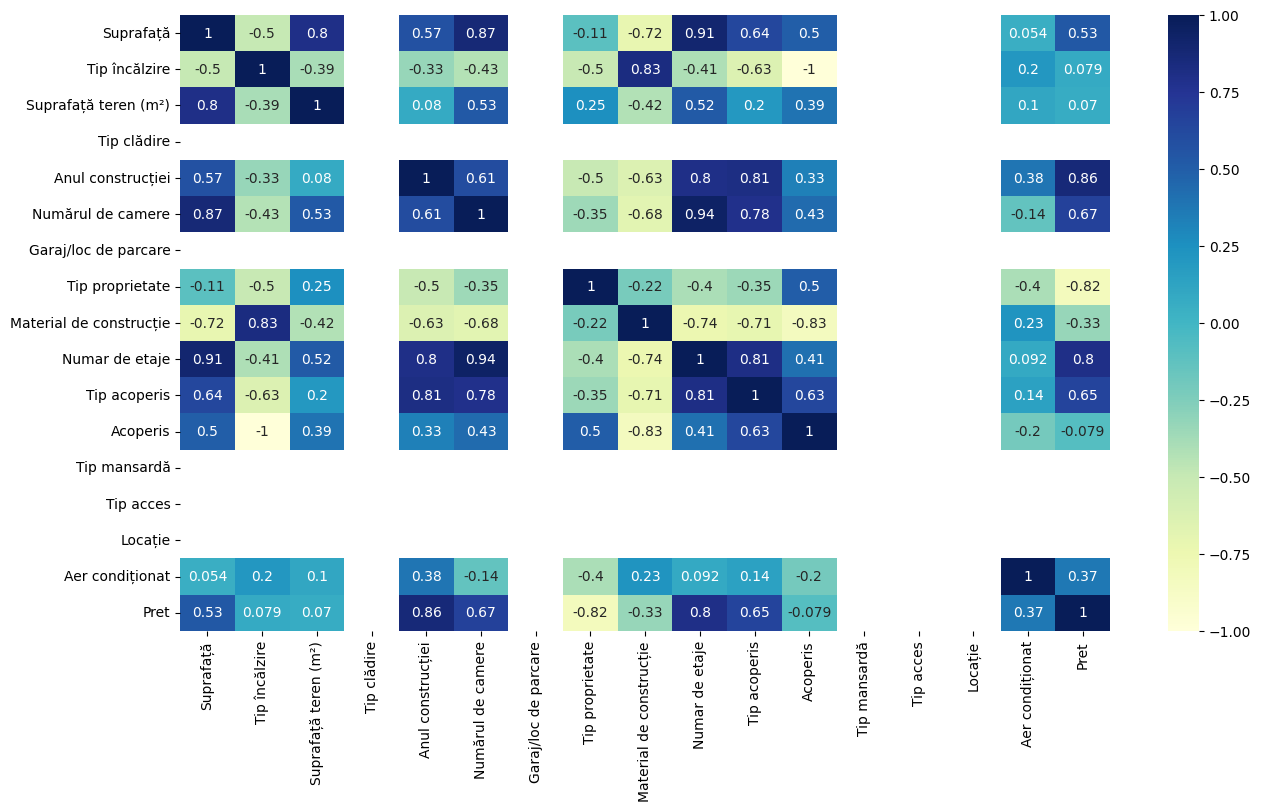

In [127]:
plt.figure(figsize=(15,8))
sns.heatmap(dfFinalizat.dropna().corr(), cmap="YlGnBu", annot=True)


In [128]:
dfShort.info()
dfShort.to_csv(r"..\CSVs\ReadyToLiveSet.csv", encoding="utf-16")

<class 'pandas.core.frame.DataFrame'>
Index: 761 entries, 1 to 1943
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Suprafață             761 non-null    float64
 1   Tip încălzire         761 non-null    int64  
 2   Suprafață teren (m²)  761 non-null    float64
 3   Anul construcției     761 non-null    float64
 4   Numărul de camere     761 non-null    float64
 5   Aer condiționat       761 non-null    int64  
 6   Pret                  761 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 47.6 KB


<Axes: >

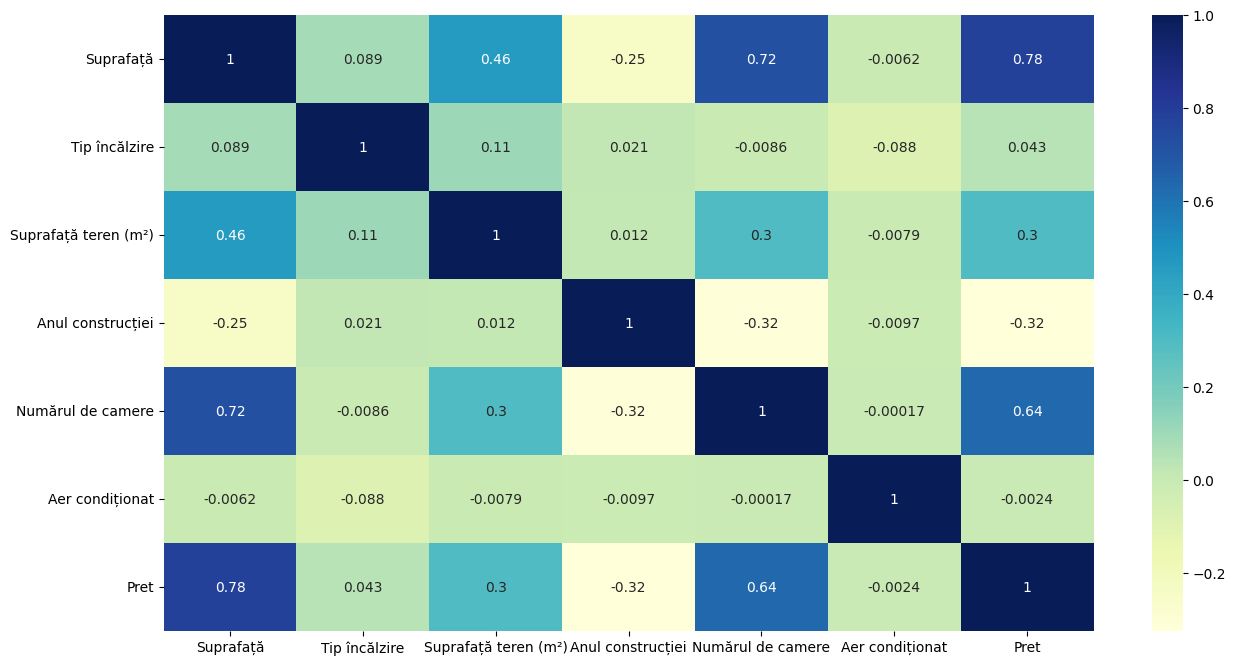

In [129]:
plt.figure(figsize=(15,8))
sns.heatmap(dfShort.corr(), cmap="YlGnBu", annot=True)

In [130]:
# for col in df:
#     df[col].bfill(inplace=True)

for col in df:
    df[col].ffill(inplace=True)

df.drop(["Garaj/loc de parcare"], axis= 1, inplace=True)

<Axes: >

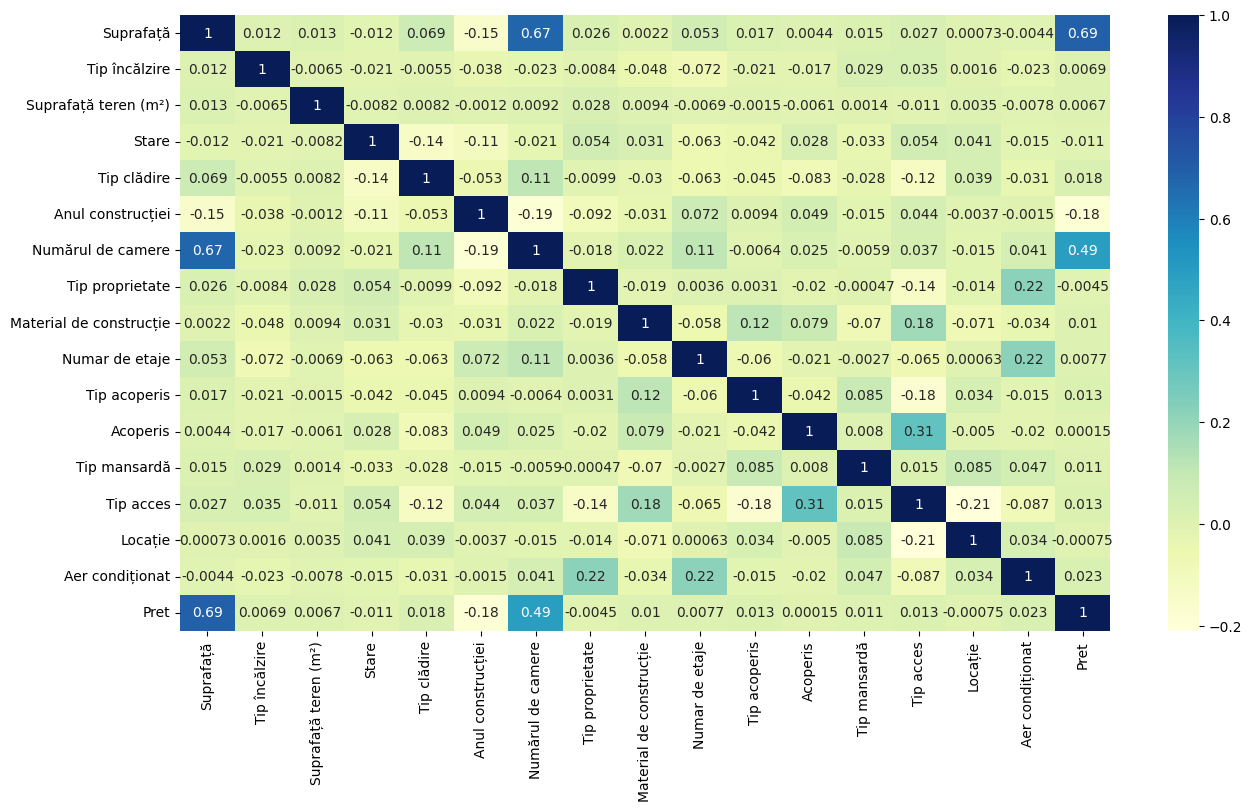

In [131]:
correlationMatrix = df.dropna().corr()
correlationMatrix.Pret

plt.figure(figsize=(15,8))
sns.heatmap(correlationMatrix, cmap="YlGnBu", annot=True)

,Suprafață,Tip încălzire,Suprafață teren (m²),Stare,Tip clădire,Anul construcției,Numărul de camere,Tip proprietate,Material de construcție,Numar de etaje,Tip acoperis,Acoperis,Tip mansardă,Tip acces,Locație,Aer condiționat,Pret
0,250.0,6,327.0,2,5,1991.0,6.0,3,7,1.0,5,3,1,1,4,0,225000.0
1,125.0,6,125.0,1,5,2003.0,3.0,2,4,1.0,5,3,2,1,4,1,175850.0
2,250.0,6,540.0,1,5,2003.0,4.0,2,4,1.0,5,3,2,1,4,0,380000.0
3,80.0,6,219.0,2,5,2003.0,4.0,3,1,1.0,5,3,2,1,4,1,125000.0
4,250.0,6,540.0,2,5,2003.0,4.0,2,1,1.0,5,3,2,1,4,0,380000.0


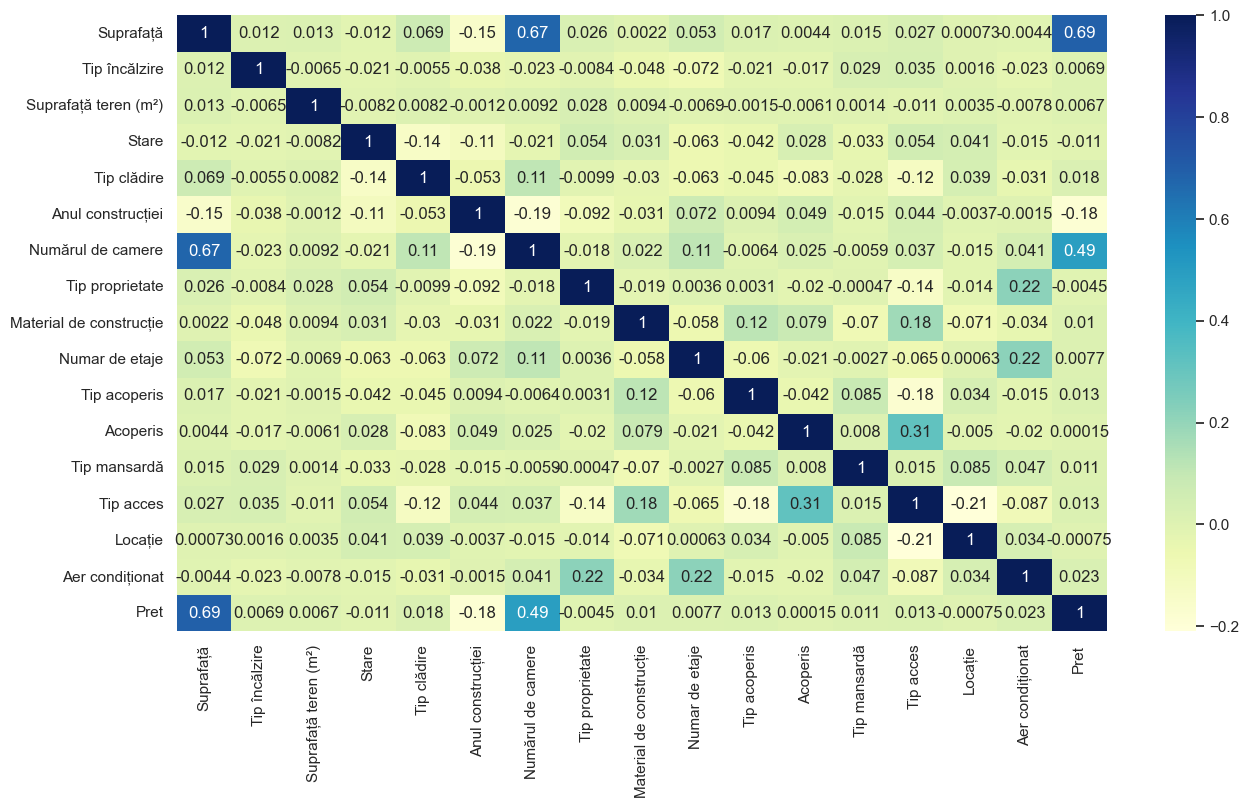

In [93]:
# df["raport casa/teren"] = df["Suprafață"]/df["Suprafață teren (m²)"]
# df.drop(["raport casa/teren"], axis=1, inplace=True)
correlationMatrix = df.corr()
plt.figure(figsize=(15,8))
sns.heatmap(correlationMatrix, cmap="YlGnBu", annot=True)
df.head()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 [Text(0, 0, 'Suprafață'),
  Text(1, 0, 'Tip încălzire'),
  Text(2, 0, 'Suprafață teren (m²)'),
  Text(3, 0, 'Stare'),
  Text(4, 0, 'Tip clădire'),
  Text(5, 0, 'Anul construcției'),
  Text(6, 0, 'Numărul de camere'),
  Text(7, 0, 'Tip proprietate'),
  Text(8, 0, 'Material de construcție'),
  Text(9, 0, 'Numar de etaje'),
  Text(10, 0, 'Tip acoperis'),
  Text(11, 0, 'Acoperis'),
  Text(12, 0, 'Tip mansardă'),
  Text(13, 0, 'Tip acces'),
  Text(14, 0, 'Locație'),
  Text(15, 0, 'Aer condiționat'),
  Text(16, 0, 'Pret')])

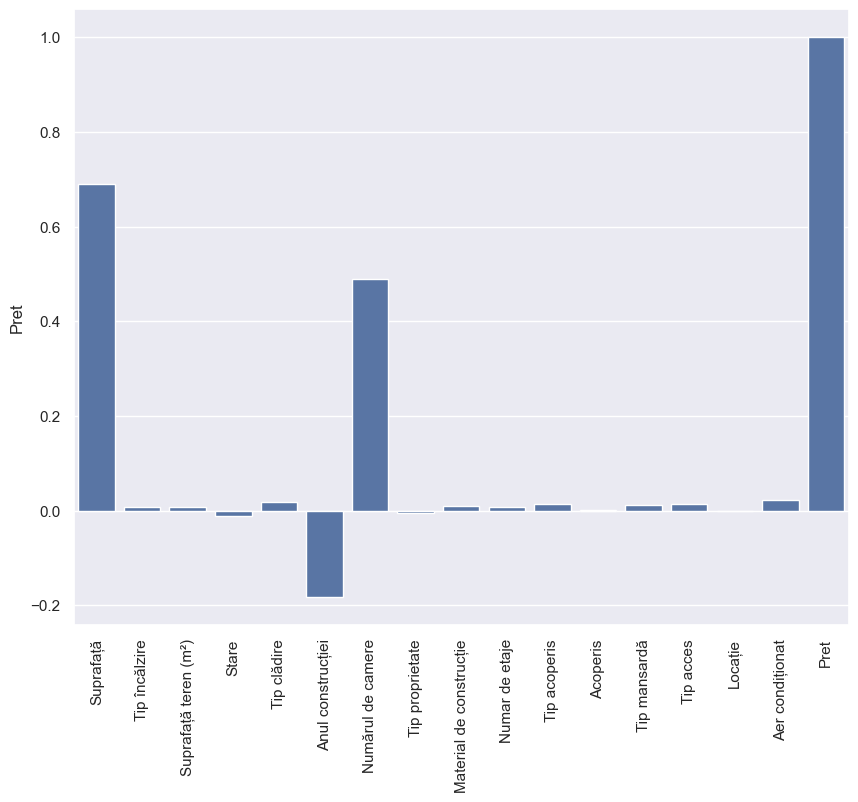

In [94]:
sns.barplot(correlationMatrix['Pret'])
plt.xticks(rotation=90)

replace numbers with categories

In [95]:
def replaceNumbersWithCategories(df):
    for column in categoryDict:
        for label in categoryDict[column]:
            df[column] = df[column].replace(categoryDict[column][label], label)
        df[column] = df[column].replace(0, "Neprecizat")

Machine Learning Algorithm:

In [96]:
df = pd.read_csv(r"..\CSVs\EditedDataSet.csv", encoding="utf-16", index_col=0)


# replace numbers with categories

dfWithLabels = df.copy()

replaceNumbersWithCategories(dfWithLabels)
        

fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 10

fig_size[1] = 8

plt.rcParams["figure.figsize"] = fig_size

sns.set_theme()

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1944 entries, 0 to 1943
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Suprafață                1944 non-null   float64
 1   Tip încălzire            1315 non-null   float64
 2   Suprafață teren (m²)     1944 non-null   float64
 3   Stare                    1106 non-null   float64
 4   Tip clădire              1267 non-null   float64
 5   Anul construcției        1506 non-null   float64
 6   Numărul de camere        1944 non-null   float64
 7   Garaj/loc de parcare     257 non-null    float64
 8   Tip proprietate          1925 non-null   float64
 9   Material de construcție  459 non-null    float64
 10  Numar de etaje           843 non-null    float64
 11  Tip acoperis             269 non-null    float64
 12  Acoperis                 375 non-null    float64
 13  Tip mansardă             184 non-null    float64
 14  Tip acces                431 

In [98]:
dfWithLabels.Stare.value_counts()

Stare
gata de utilizare                  936
necesită renovare                  141
în construcție                      24
în construcție  faza avansată        4
în construcție  faza incipientă      1
Name: count, dtype: int64

In [100]:
dfWithLabels["Garaj/loc de parcare"].value_counts()

Garaj/loc de parcare
garaj    257
Name: count, dtype: int64

In [101]:
dfWithLabels["Suprafață teren (m²)"].value_counts()

Suprafață teren (m²)
250.0    103
200.0     95
100.0     93
300.0     75
150.0     55
        ... 
632.0      1
154.0      1
310.0      1
960.0      1
328.0      1
Name: count, Length: 452, dtype: int64

(0.0, 5000000.0)

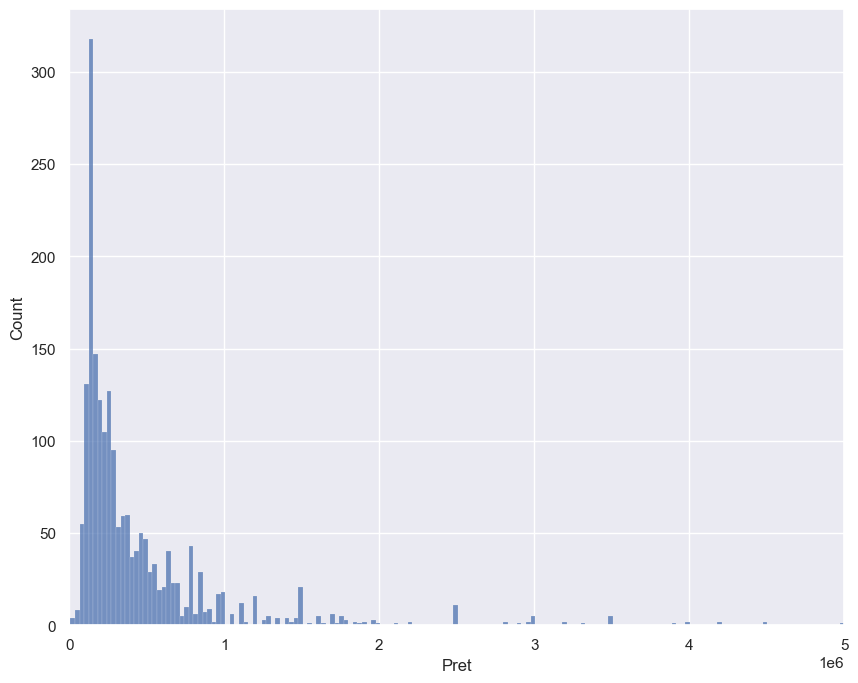

In [102]:
sns.histplot(df['Pret'], kde=False, bins=500)
plt.xlim(0, 1e7 * 0.5)

<Axes: xlabel='Suprafață', ylabel='Pret'>

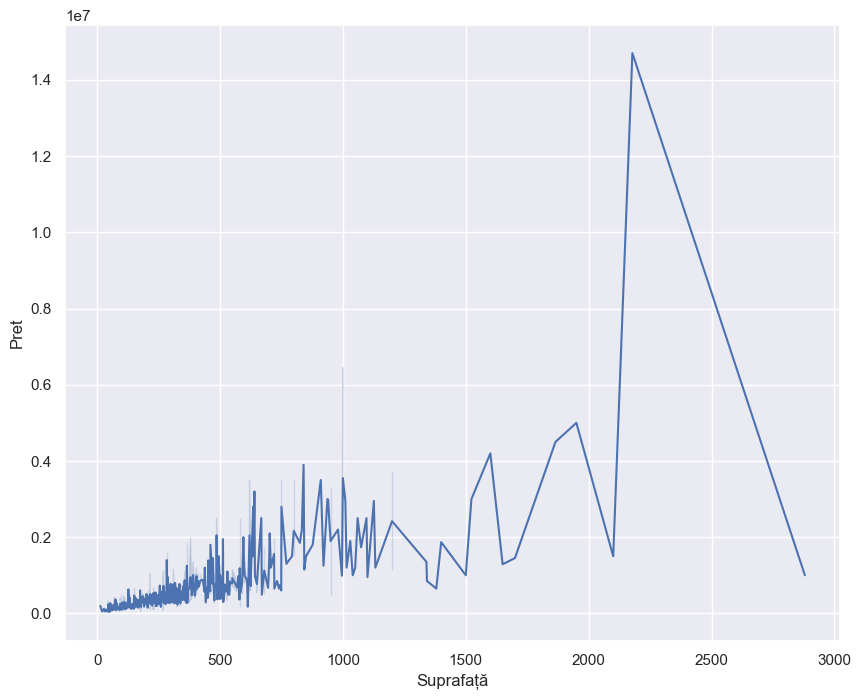

In [16]:
sns.lineplot(x="Suprafață", y="Pret", data=df)

<Axes: xlabel='Pret', ylabel='Tip încălzire'>

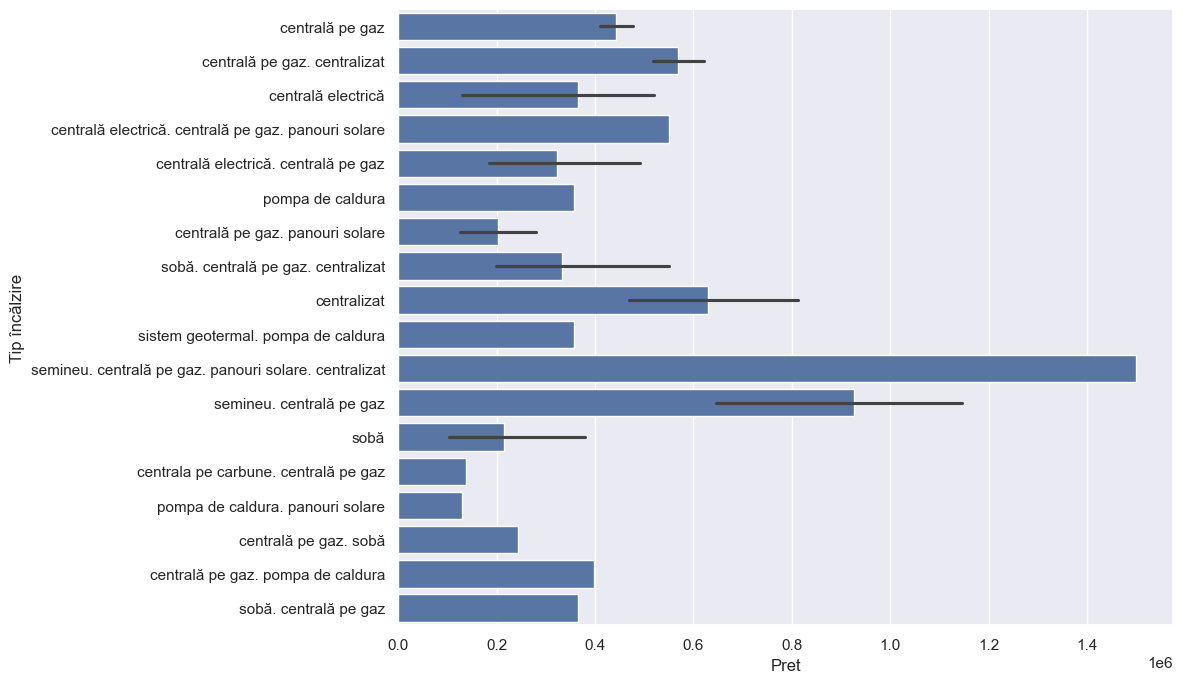

In [17]:
sns.barplot(x="Pret", y="Tip încălzire", data=dfWithLabels)

(0.0, 3500.0)

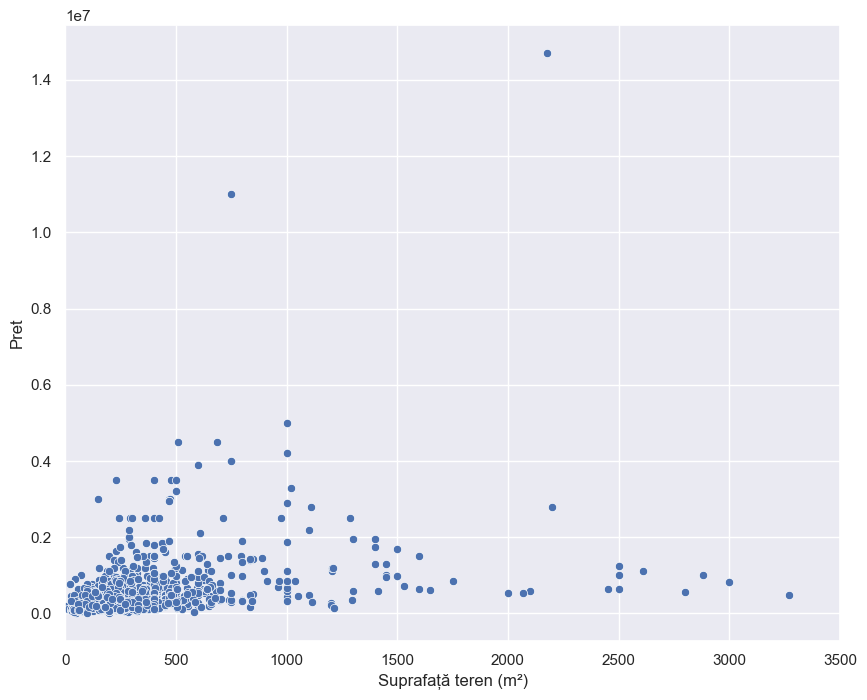

In [18]:
sns.scatterplot(x="Suprafață teren (m²)", y="Pret", data=df)
plt.xlim(0, 3500)

<Axes: xlabel='Pret', ylabel='Stare'>

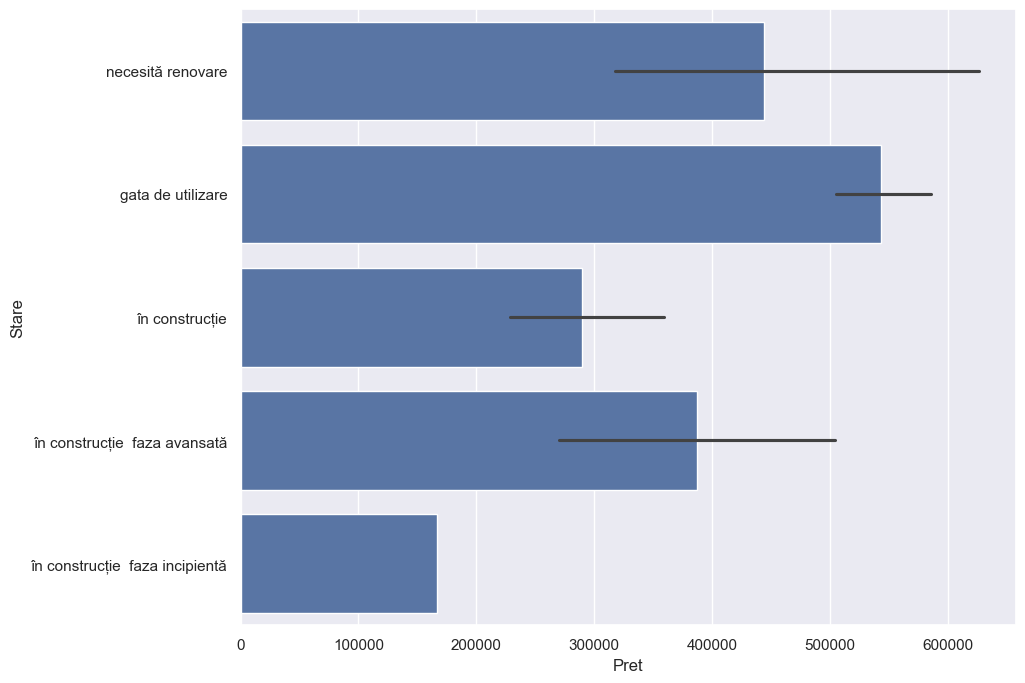

In [19]:
sns.barplot(x="Pret", y="Stare", data=dfWithLabels)

<Axes: xlabel='Tip clădire', ylabel='Pret'>

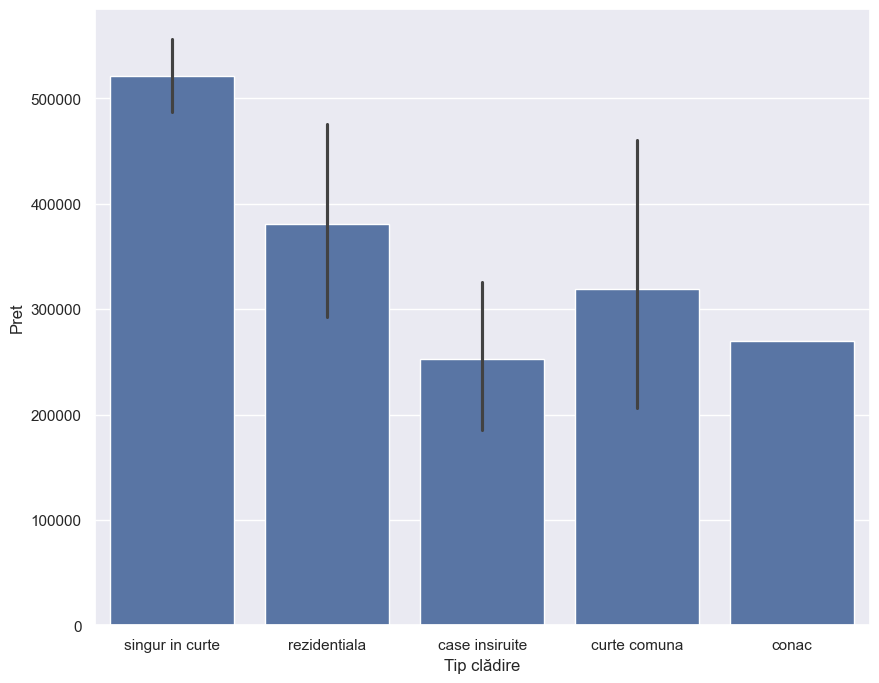

In [20]:
sns.barplot(x="Tip clădire", y="Pret", data=dfWithLabels)

(1850.0, 2050.0)

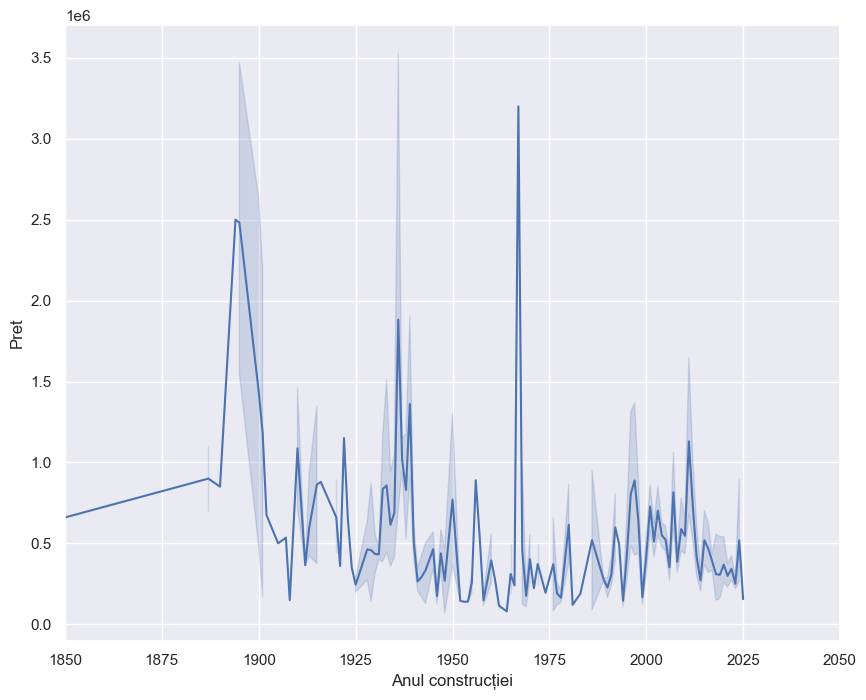

In [21]:
x = sns.lineplot(x="Anul construcției", y="Pret", data=df)
plt.xlim(1850, 2050)

<Axes: xlabel='Numărul de camere', ylabel='Pret'>

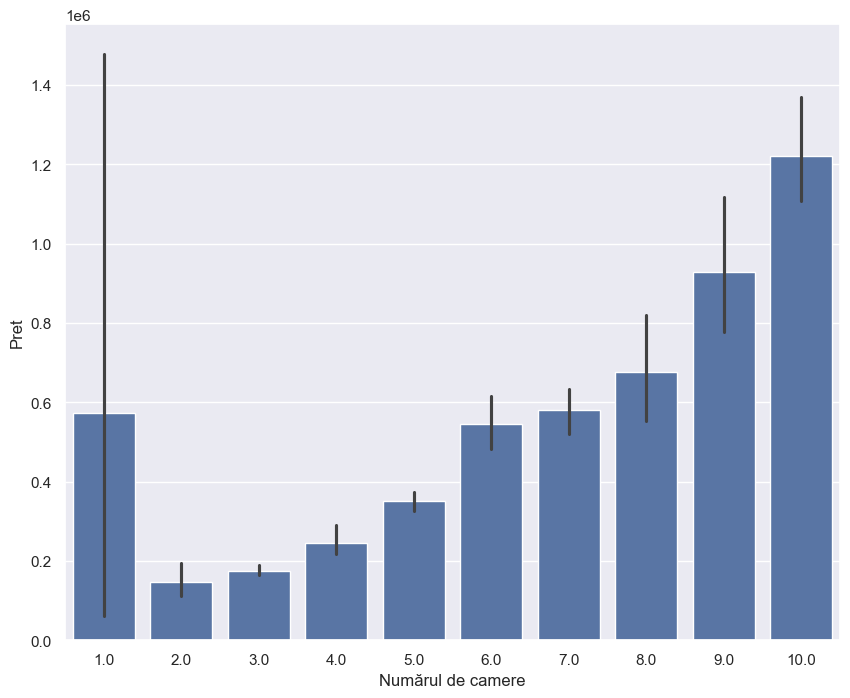

In [22]:
sns.barplot(x="Numărul de camere", y="Pret", data=df)

<Axes: xlabel='Garaj/loc de parcare', ylabel='Pret'>

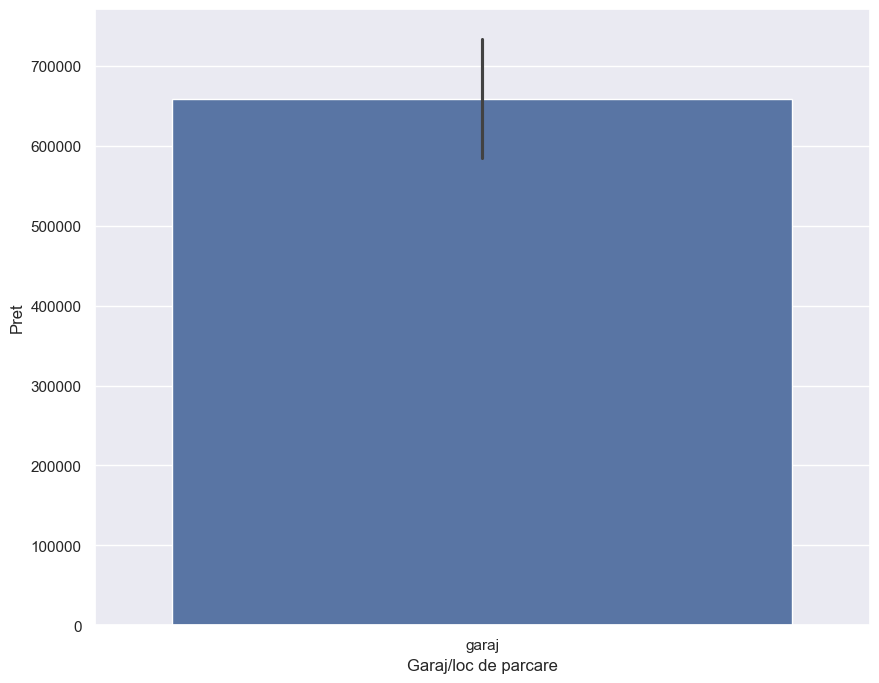

In [23]:
sns.barplot(x="Garaj/loc de parcare", y="Pret", data=dfWithLabels)

<Axes: xlabel='Tip proprietate', ylabel='Pret'>

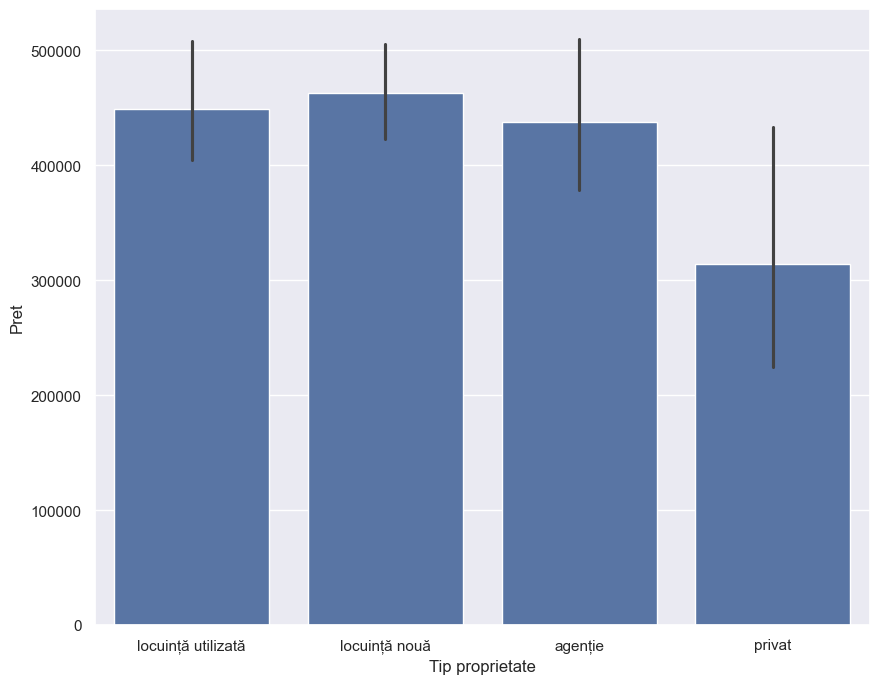

In [24]:
sns.barplot(x="Tip proprietate", y="Pret", data=dfWithLabels)

<Axes: xlabel='Pret', ylabel='Material de construcție'>

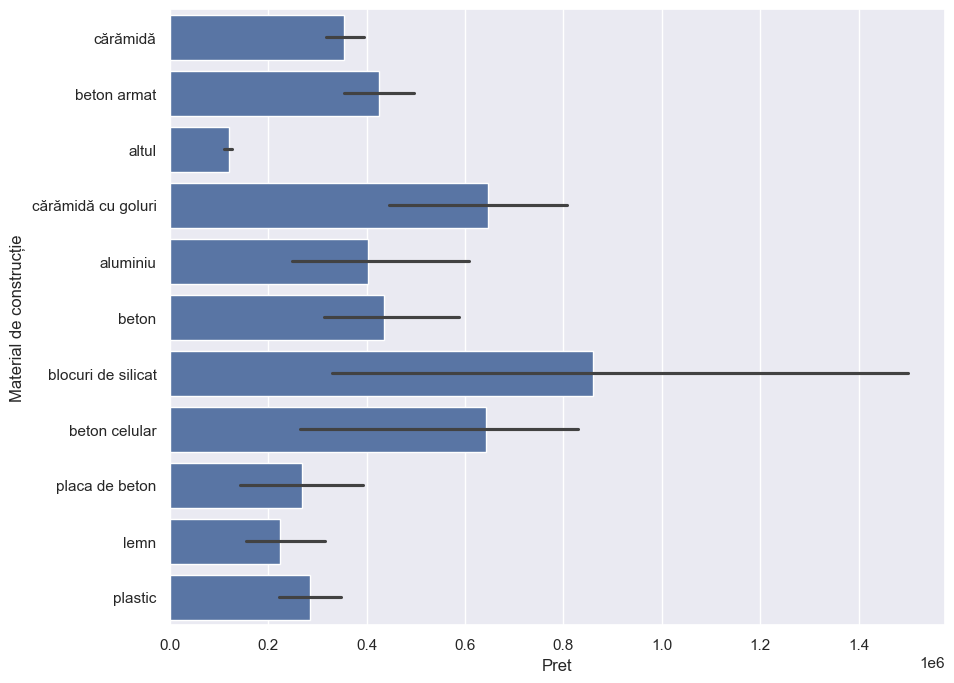

In [25]:
sns.barplot(x="Pret", y="Material de construcție", data=dfWithLabels)

<Axes: xlabel='Numar de etaje', ylabel='Pret'>

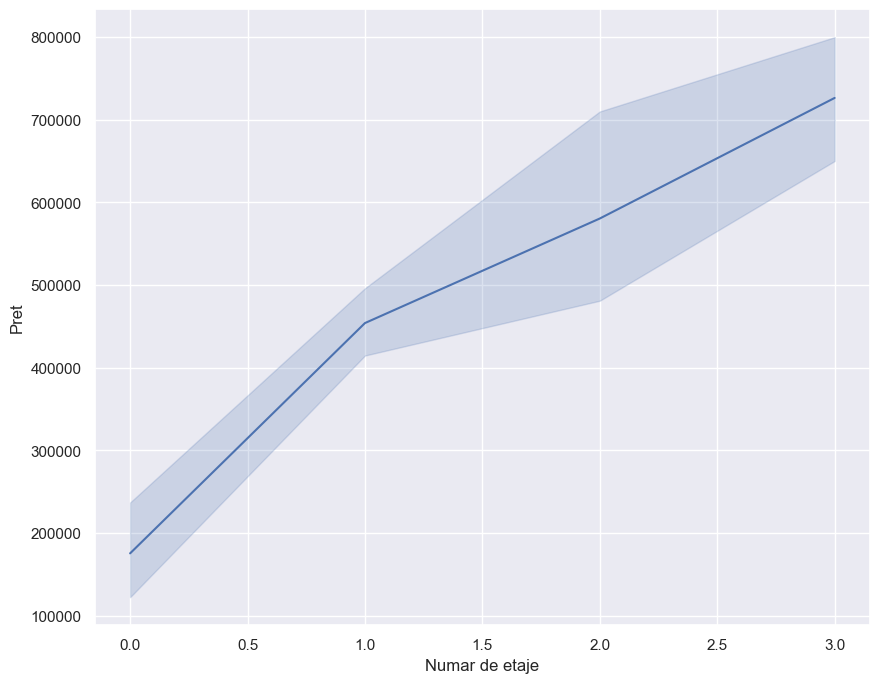

In [26]:
sns.lineplot(x="Numar de etaje", y="Pret", data=dfWithLabels)

<Axes: xlabel='Tip acoperis', ylabel='Pret'>

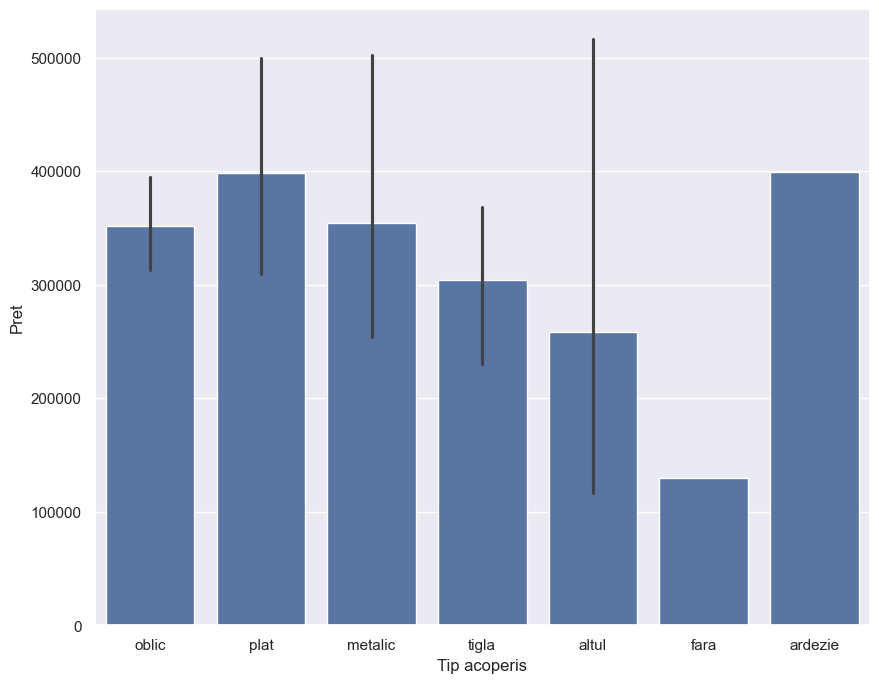

In [27]:
sns.barplot(x="Tip acoperis", y="Pret", data=dfWithLabels)

<Axes: xlabel='Acoperis', ylabel='Pret'>

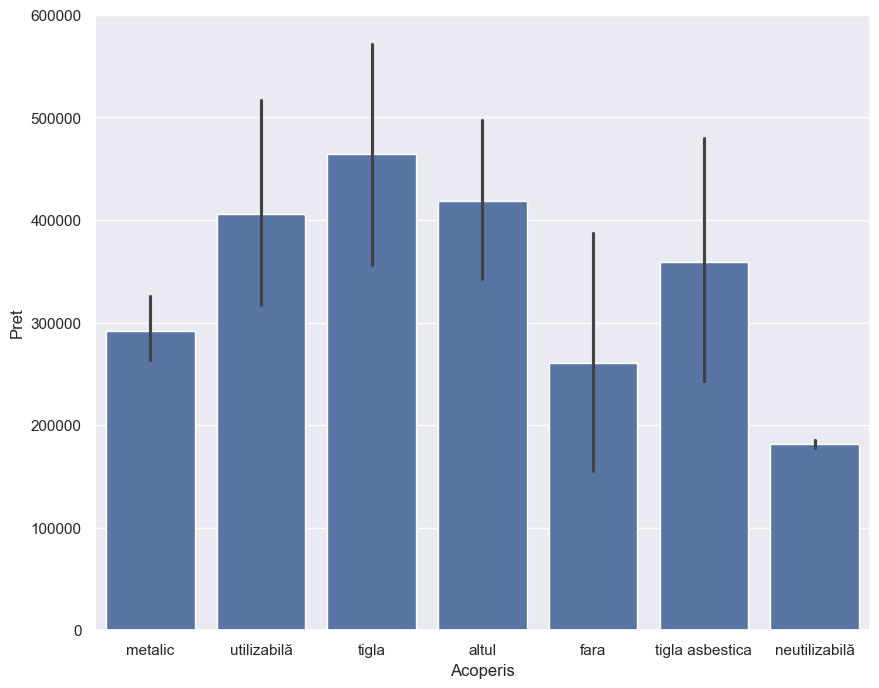

In [28]:
sns.barplot(x="Acoperis", y="Pret", data=dfWithLabels)

<Axes: xlabel='Tip mansardă', ylabel='Pret'>

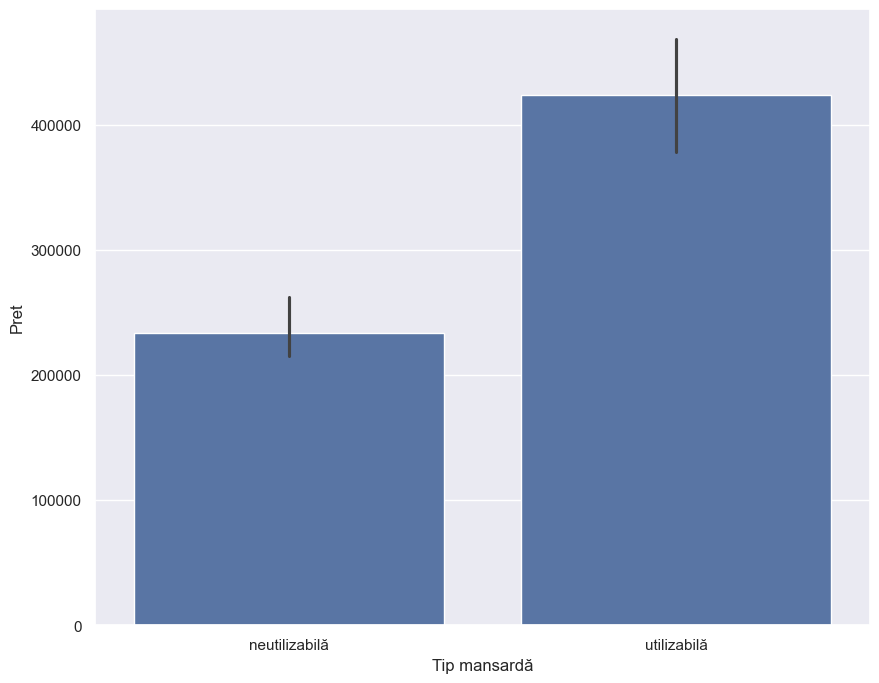

In [29]:
sns.barplot(x="Tip mansardă", y="Pret", data=dfWithLabels)

<Axes: xlabel='Pret', ylabel='Tip acces'>

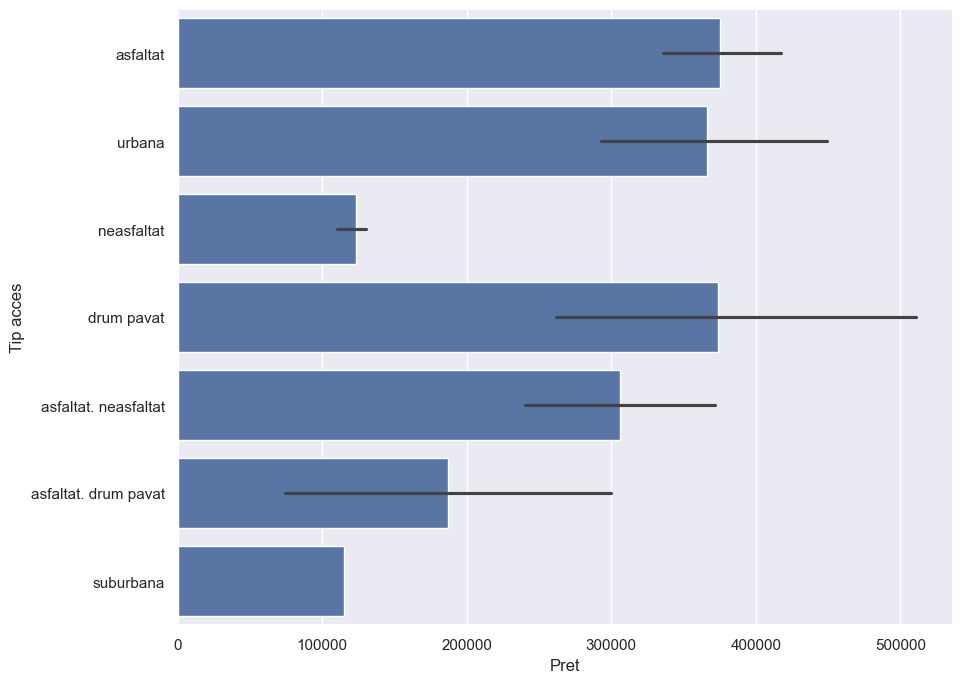

In [30]:
sns.barplot(x="Pret", y="Tip acces", data=dfWithLabels)

<Axes: xlabel='Locație', ylabel='Pret'>

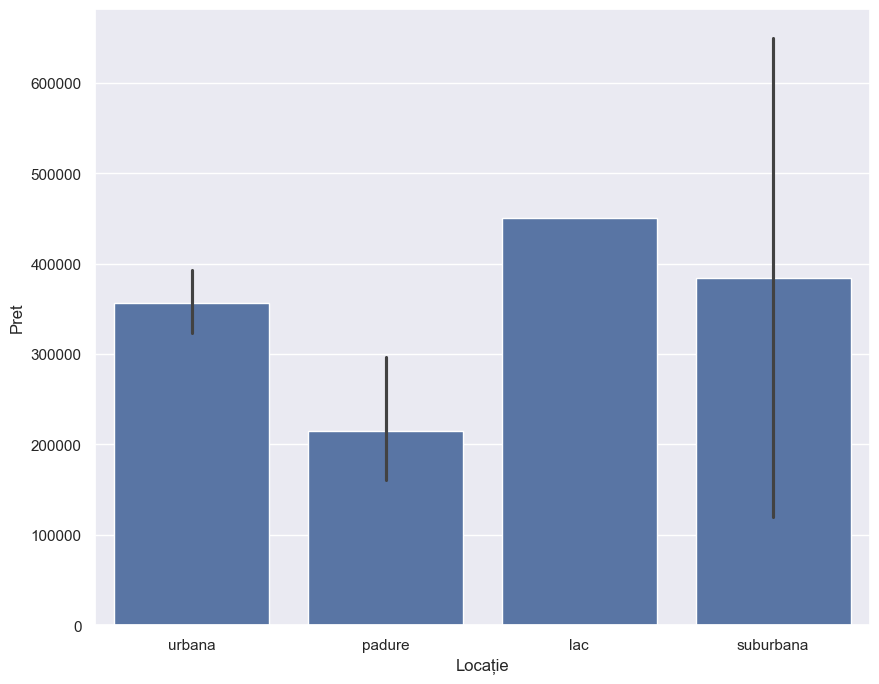

In [31]:
sns.barplot(x="Locație", y="Pret", data=dfWithLabels)

<Axes: xlabel='Aer condiționat', ylabel='Pret'>

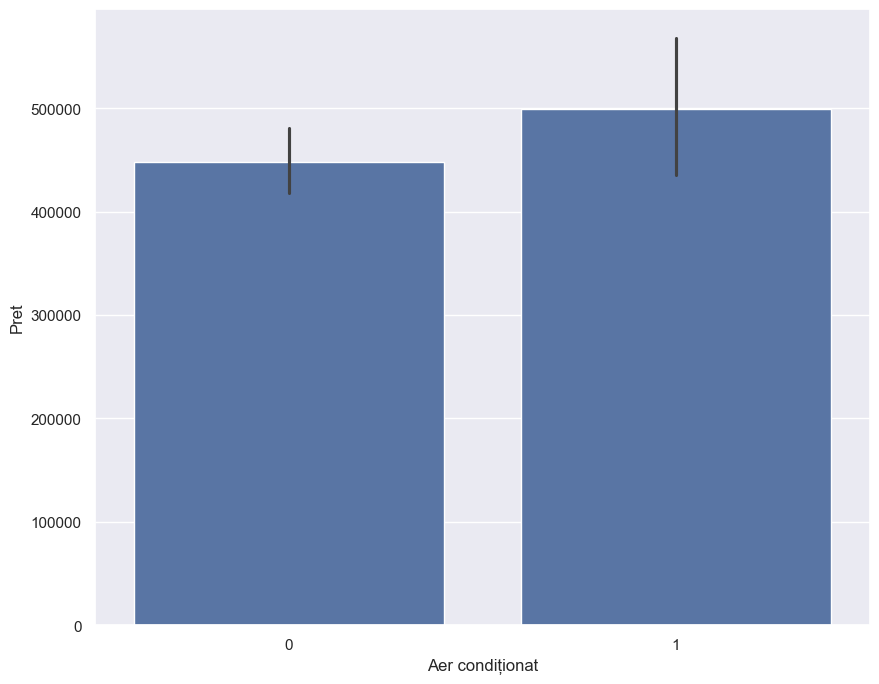

In [32]:
sns.barplot(x="Aer condiționat", y="Pret", data=dfWithLabels)

array([[<Axes: title={'center': 'Suprafață'}>,
        <Axes: title={'center': 'Tip încălzire'}>,
        <Axes: title={'center': 'Suprafață teren (m²)'}>,
        <Axes: title={'center': 'Stare'}>],
       [<Axes: title={'center': 'Tip clădire'}>,
        <Axes: title={'center': 'Anul construcției'}>,
        <Axes: title={'center': 'Numărul de camere'}>,
        <Axes: title={'center': 'Garaj/loc de parcare'}>],
       [<Axes: title={'center': 'Tip proprietate'}>,
        <Axes: title={'center': 'Material de construcție'}>,
        <Axes: title={'center': 'Numar de etaje'}>,
        <Axes: title={'center': 'Tip acoperis'}>],
       [<Axes: title={'center': 'Acoperis'}>,
        <Axes: title={'center': 'Tip mansardă'}>,
        <Axes: title={'center': 'Tip acces'}>,
        <Axes: title={'center': 'Locație'}>],
       [<Axes: title={'center': 'Aer condiționat'}>,
        <Axes: title={'center': 'Pret'}>, <Axes: >, <Axes: >]],
      dtype=object)

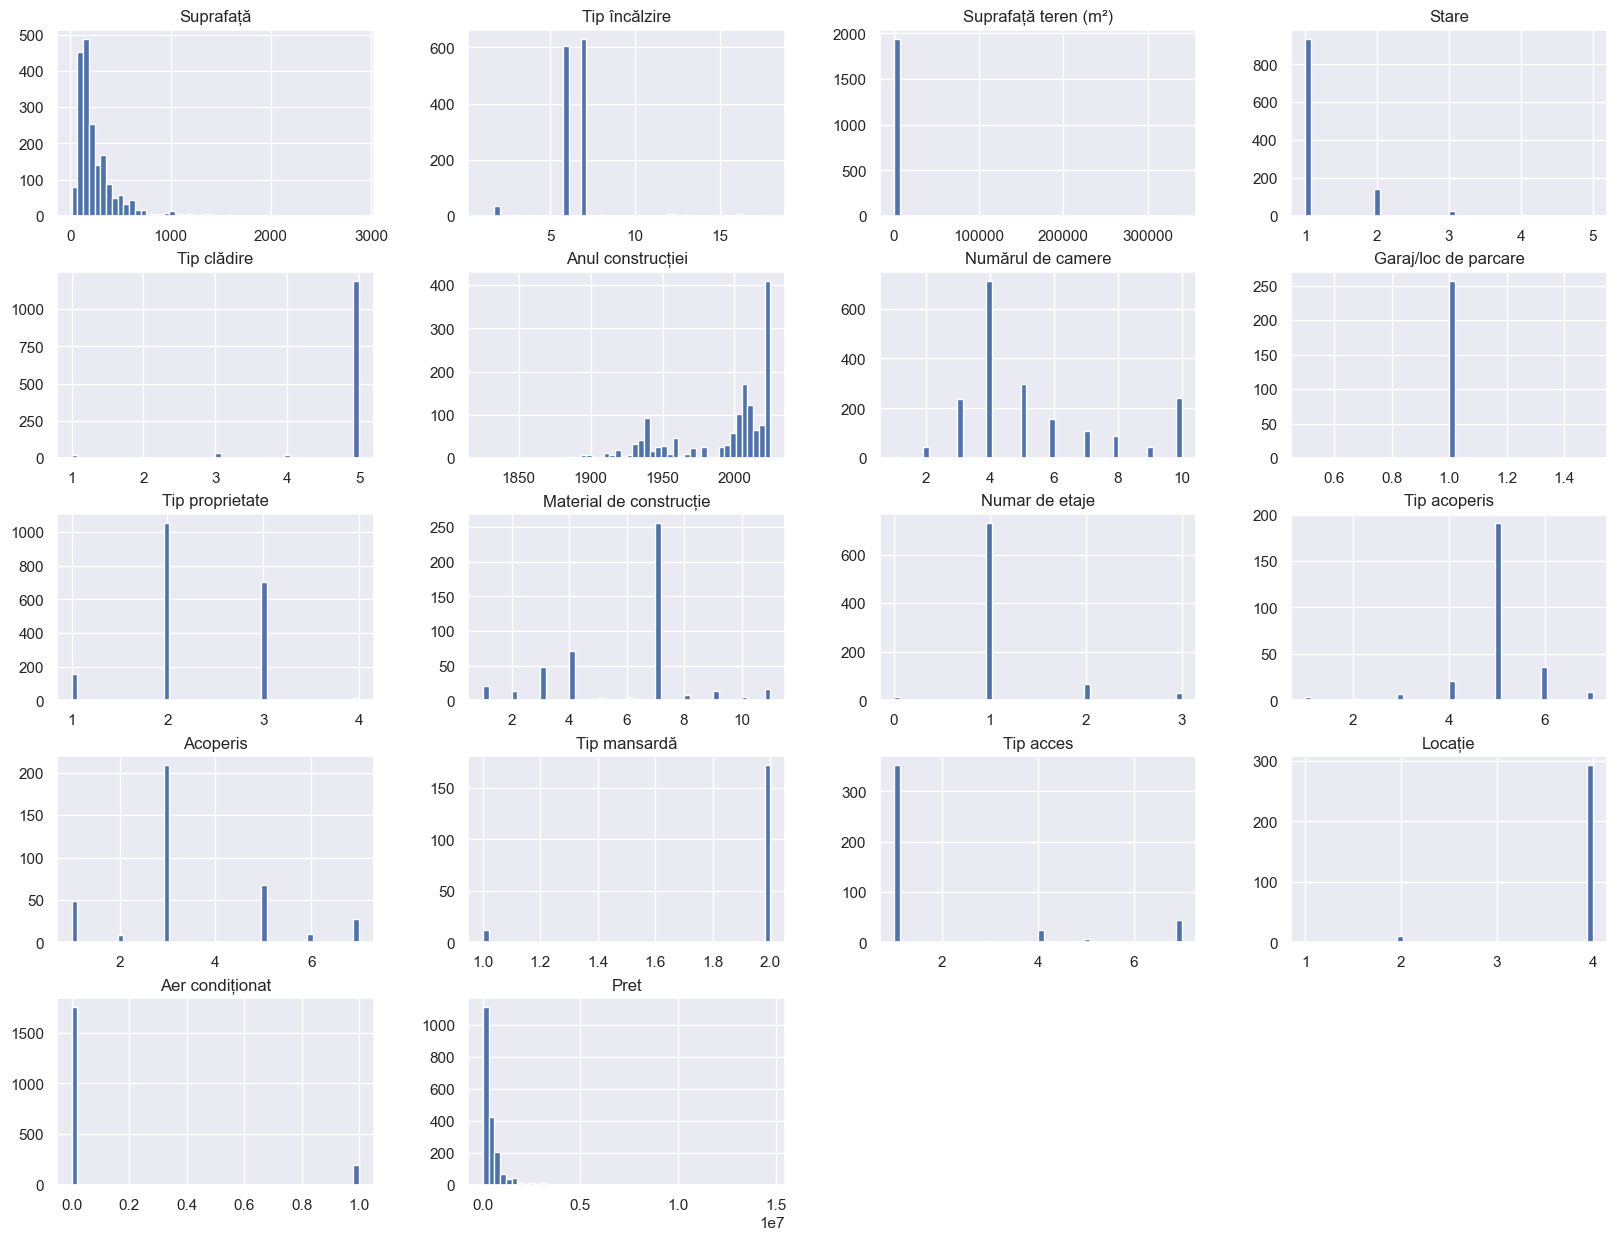

In [103]:
df.hist(bins=50, figsize=(20,15))

Removing outliers

In [104]:
display(df)

,Suprafață,Tip încălzire,Suprafață teren (m²),Stare,Tip clădire,Anul construcției,Numărul de camere,Garaj/loc de parcare,Tip proprietate,Material de construcție,Numar de etaje,Tip acoperis,Acoperis,Tip mansardă,Tip acces,Locație,Aer condiționat,Pret
0,250.0,6.0,327.0,2.0,5.0,1991.0,6.0,NaN,3.0,7.0,1.0,5.0,3.0,1.0,1.0,4.0,0,225000.0
1,125.0,6.0,125.0,1.0,5.0,2003.0,3.0,1.0,2.0,4.0,1.0,NaN,3.0,2.0,1.0,4.0,1,175850.0
2,250.0,NaN,540.0,NaN,NaN,NaN,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,380000.0
3,80.0,6.0,219.0,2.0,5.0,NaN,4.0,NaN,3.0,1.0,1.0,NaN,NaN,NaN,1.0,4.0,1,125000.0
4,250.0,NaN,540.0,NaN,NaN,NaN,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,380000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,122.0,6.0,330.0,1.0,5.0,2023.0,3.0,NaN,2.0,7.0,1.0,5.0,3.0,NaN,1.0,NaN,0,125000.0
1940,165.0,NaN,120.0,NaN,5.0,1978.0,6.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,209000.0
1941,480.0,6.0,269.0,2.0,5.0,2016.0,10.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0,249000.0
1942,140.0,NaN,140.0,NaN,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,195000.0


In [132]:
def removeOutliers(column, df):

    percentile25 = df[column].quantile(0.25)
    percentile75 = df[column].quantile(0.75)
    iqr = percentile75-percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    new_df = df[df[column] < upper_limit]
    # new_df = new_df[df[column] > lower_limit]

    return new_df

def capOutliers(column, df):
    percentile25 = df[column].quantile(0.25)
    percentile75 = df[column].quantile(0.75)
    iqr = percentile75-percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    new_df_cap = df.copy()
    new_df_cap[column] = np.where(
    new_df_cap[column] > upper_limit,
    upper_limit,
    np.where(
        new_df_cap[column] < lower_limit,
        lower_limit,
        new_df_cap[column]))
    return new_df_cap

new_df = removeOutliers("Suprafață", df)
new_df = removeOutliers("Suprafață teren (m²)", new_df)
new_df = removeOutliers("Pret", new_df)
new_df_cap = capOutliers("Suprafață", df)
new_df_cap = capOutliers("Suprafață teren (m²)", new_df_cap)
new_df_cap = capOutliers("Pret", new_df_cap)
new_dfShort_cap = capOutliers("Suprafață", dfShort)
new_dfShort_cap = capOutliers("Suprafață teren (m²)", new_dfShort_cap)
new_dfShort_cap = capOutliers("Pret", new_dfShort_cap)

new_df_cap.to_csv(r"..\CSVs\EditedDataSet_df-cap.csv", encoding="utf-16", index=0)
new_dfShort_cap.to_csv(r"..\CSVs\EditedDataSet_dfShort-cap.csv", encoding="utf-16", index=0)

array([[<Axes: title={'center': 'Suprafață'}>,
        <Axes: title={'center': 'Tip încălzire'}>,
        <Axes: title={'center': 'Suprafață teren (m²)'}>,
        <Axes: title={'center': 'Stare'}>],
       [<Axes: title={'center': 'Tip clădire'}>,
        <Axes: title={'center': 'Anul construcției'}>,
        <Axes: title={'center': 'Numărul de camere'}>,
        <Axes: title={'center': 'Tip proprietate'}>],
       [<Axes: title={'center': 'Material de construcție'}>,
        <Axes: title={'center': 'Numar de etaje'}>,
        <Axes: title={'center': 'Tip acoperis'}>,
        <Axes: title={'center': 'Acoperis'}>],
       [<Axes: title={'center': 'Tip mansardă'}>,
        <Axes: title={'center': 'Tip acces'}>,
        <Axes: title={'center': 'Locație'}>,
        <Axes: title={'center': 'Aer condiționat'}>],
       [<Axes: title={'center': 'Pret'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

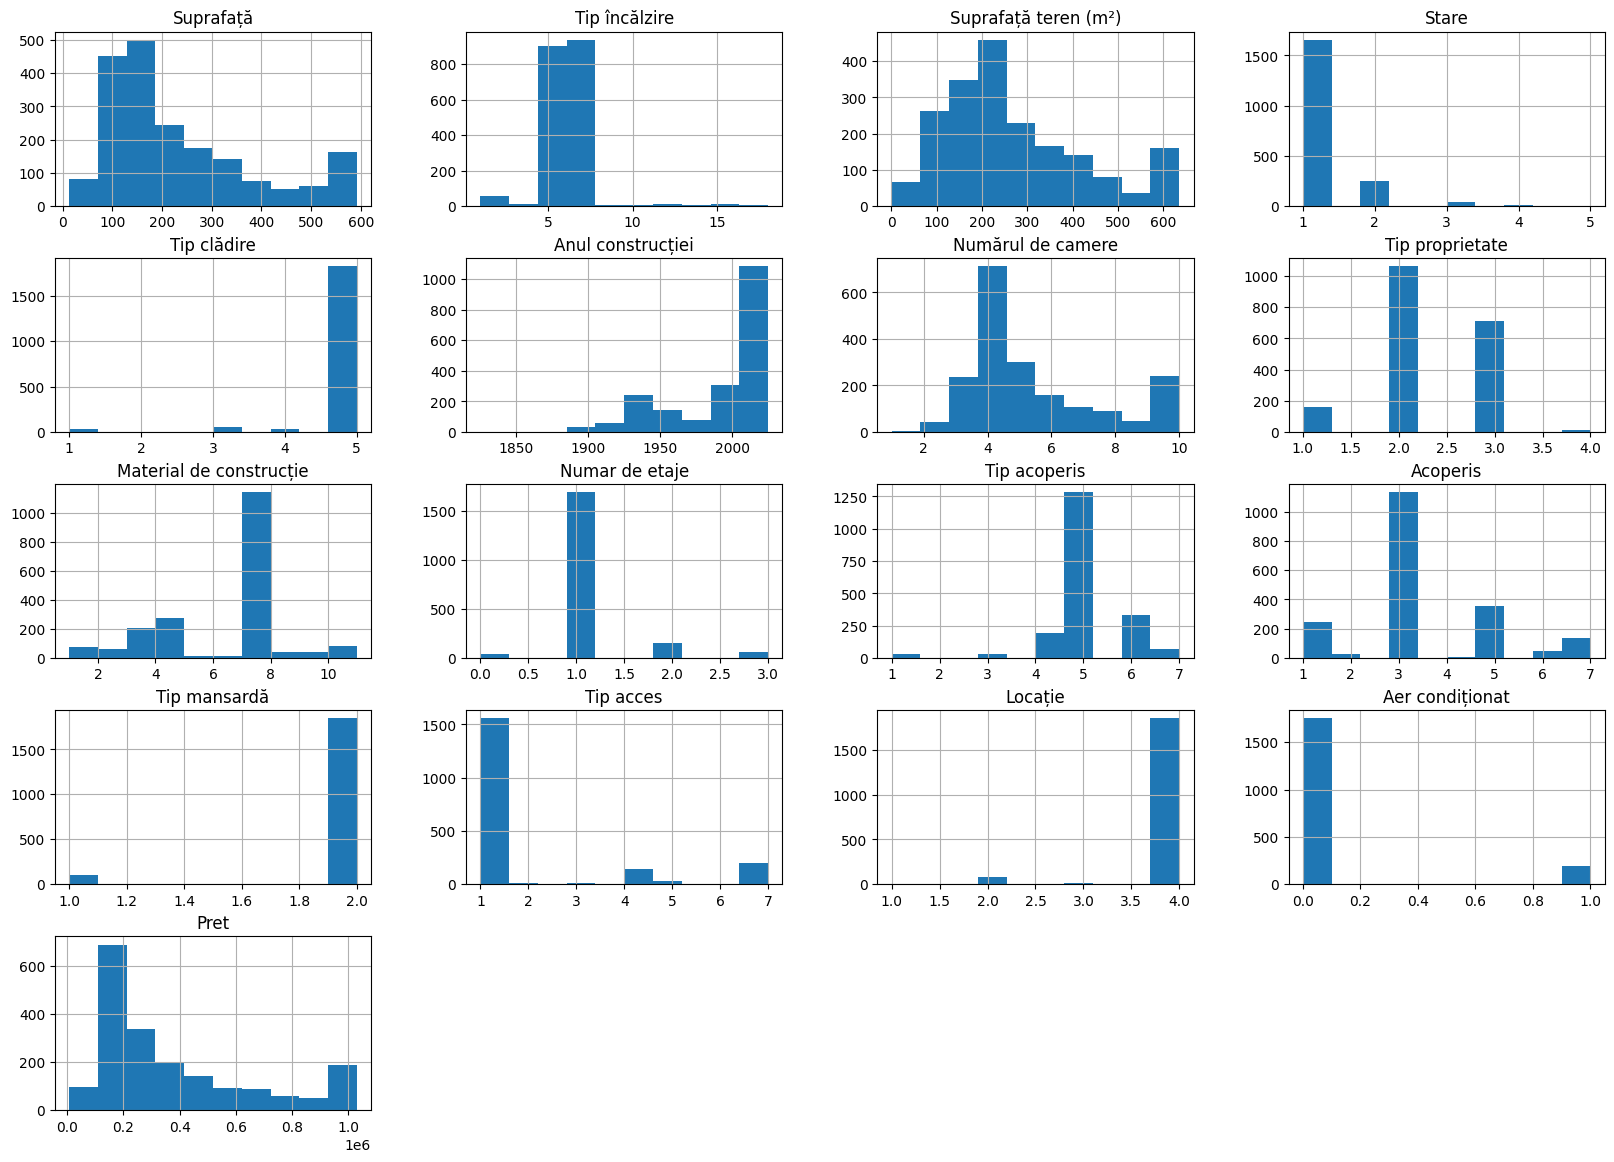

In [133]:
new_df_cap.hist(figsize=(20,14))

array([[<Axes: title={'center': 'Suprafață'}>,
        <Axes: title={'center': 'Tip încălzire'}>,
        <Axes: title={'center': 'Suprafață teren (m²)'}>],
       [<Axes: title={'center': 'Anul construcției'}>,
        <Axes: title={'center': 'Numărul de camere'}>,
        <Axes: title={'center': 'Aer condiționat'}>],
       [<Axes: title={'center': 'Pret'}>, <Axes: >, <Axes: >]],
      dtype=object)

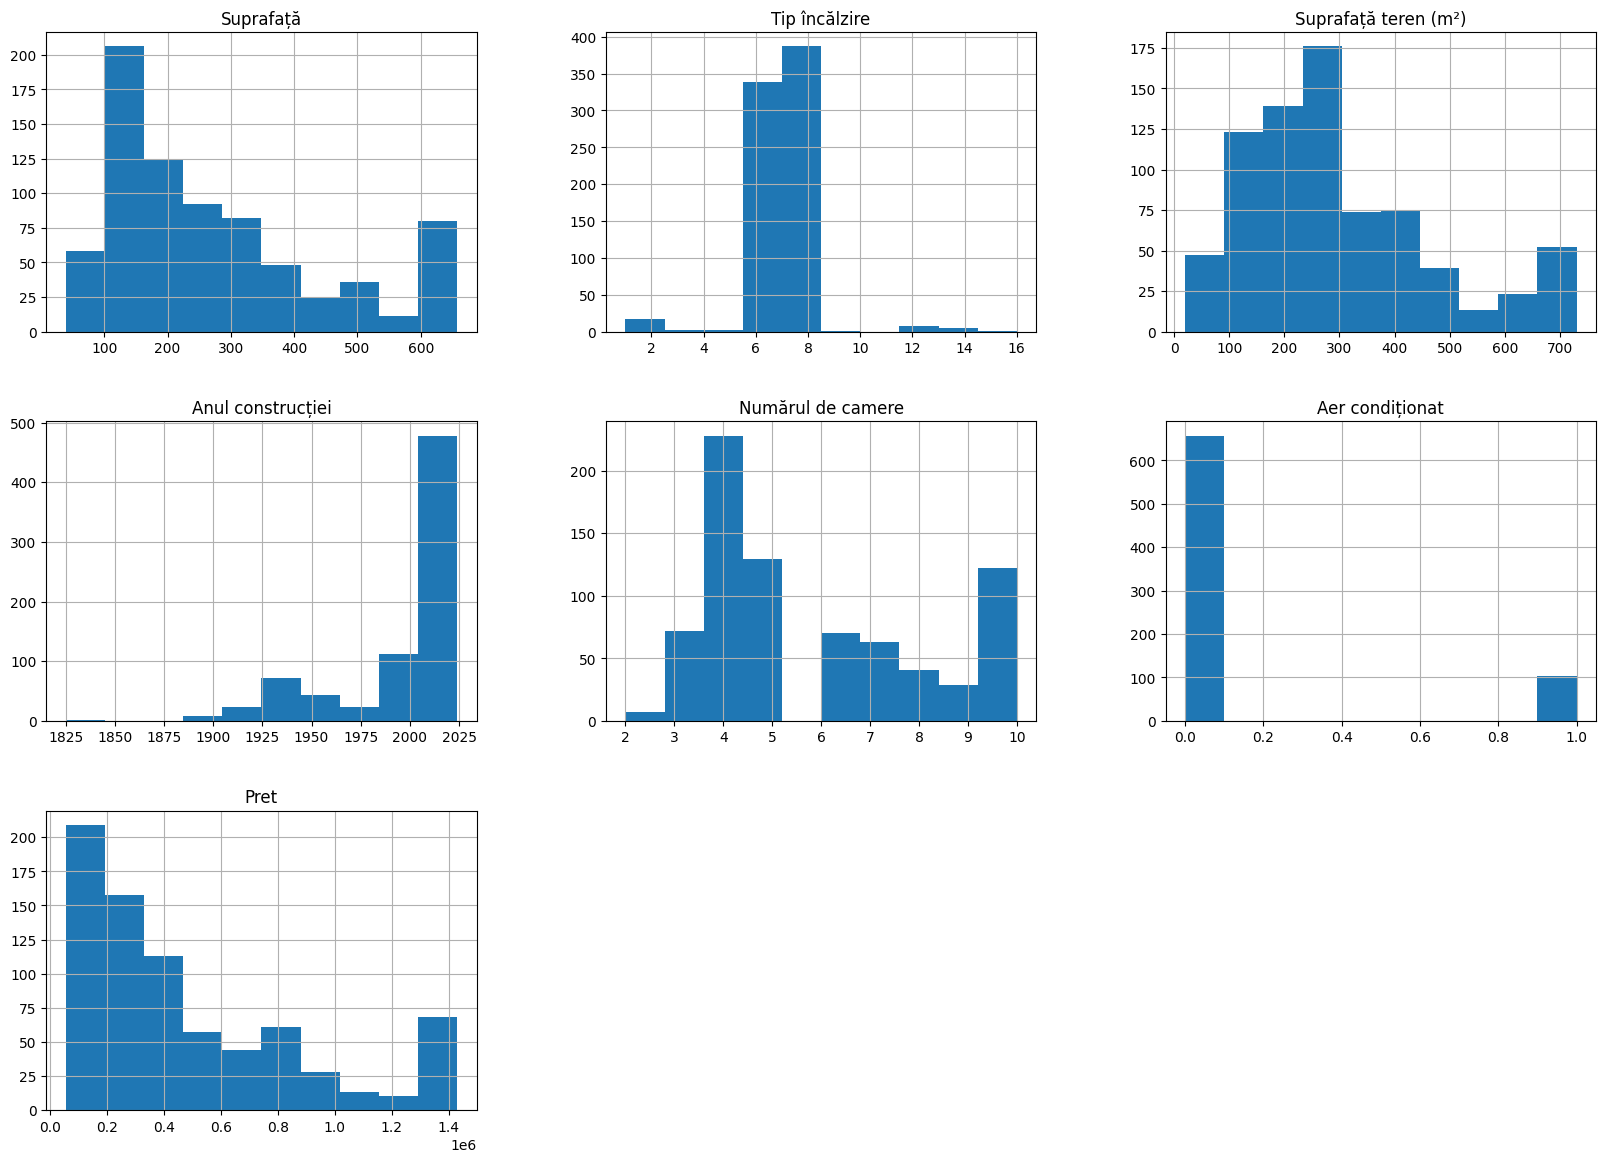

In [134]:
new_dfShort_cap.hist(figsize=(20, 14))

In [64]:
new_df_cap.Pret.value_counts()

Pret
1030625.0    152
125000.0     110
145000.0      54
150000.0      38
115000.0      31
            ... 
545000.0       1
849990.0       1
530010.0       1
92000.0        1
209000.0       1
Name: count, Length: 436, dtype: int64

array([[<Axes: title={'center': 'Suprafață'}>,
        <Axes: title={'center': 'Suprafață teren (m²)'}>],
       [<Axes: title={'center': 'Numărul de camere'}>,
        <Axes: title={'center': 'Aer condiționat'}>],
       [<Axes: title={'center': 'Pret'}>, <Axes: >]], dtype=object)

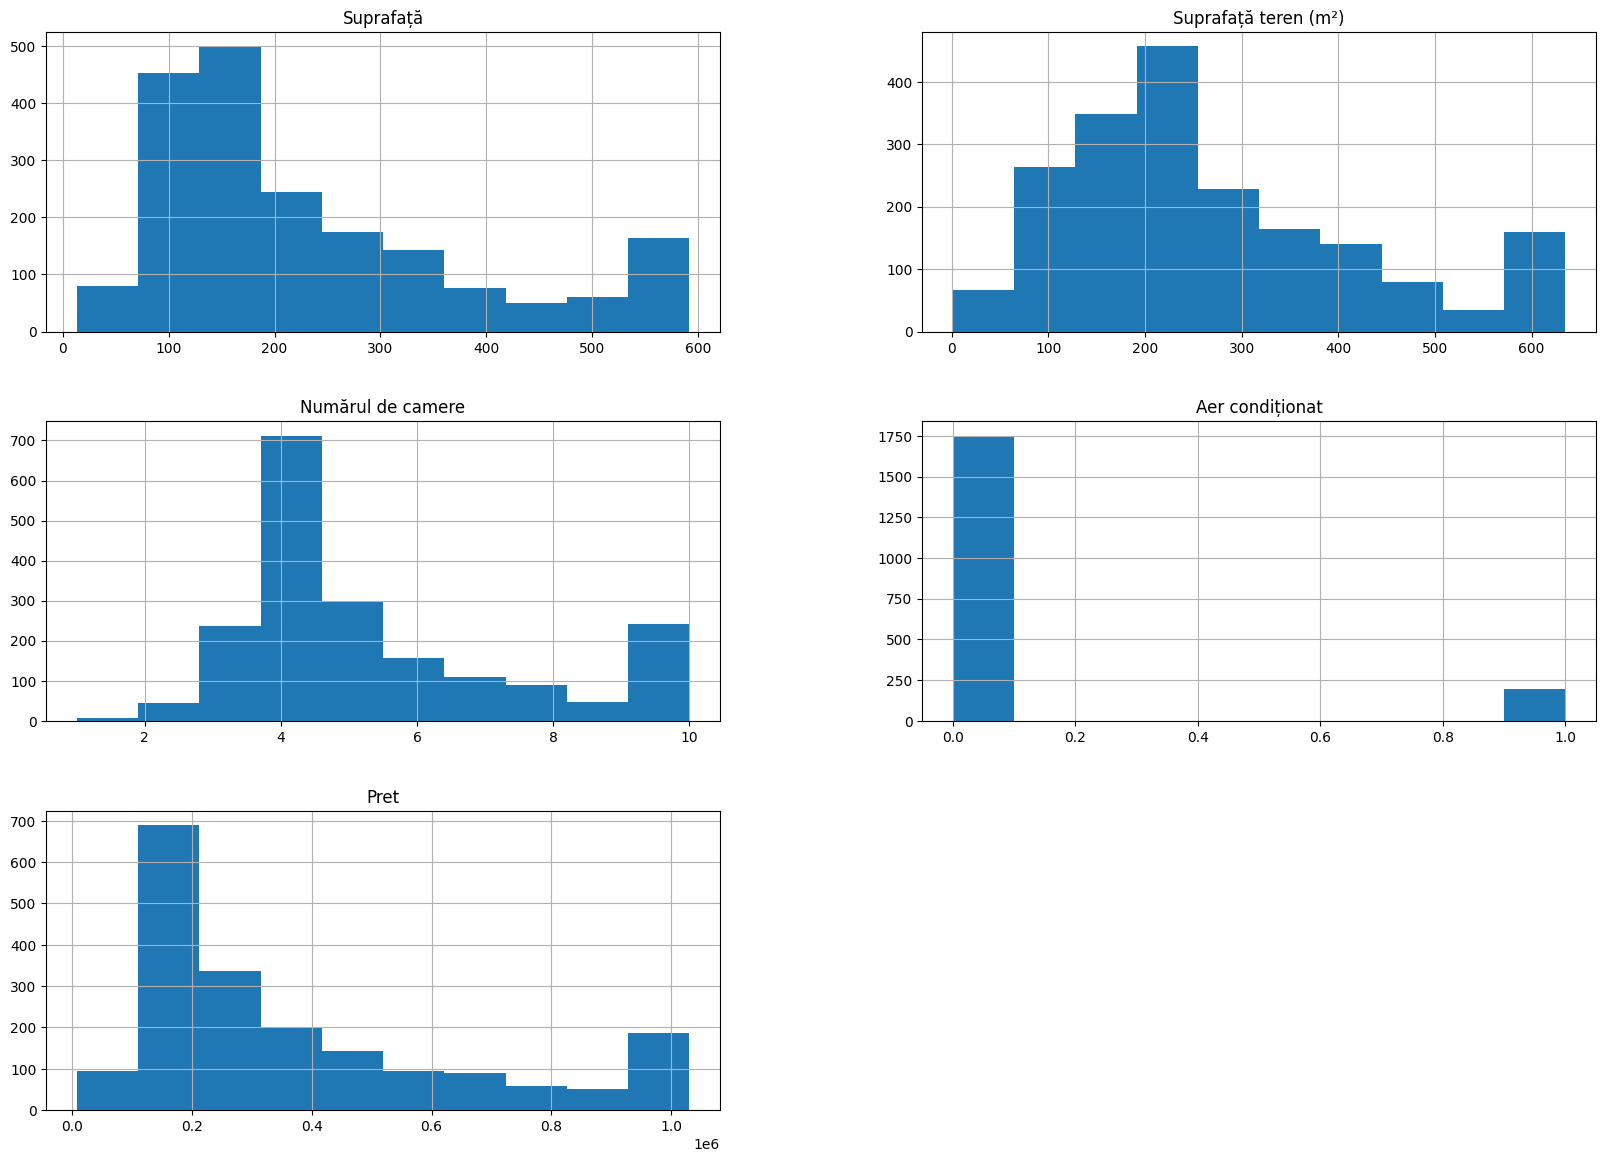

In [65]:
new_df_cap.hist(figsize=(20,14))

In [81]:
new_df_cap.ffill(inplace=True)
new_df_cap.fillna(0, inplace=True)

In [82]:
value = new_df_cap.isnull().values.any()
print(value)

False


Urmeaza impartirea datelor in portiunile de Train dataset si Test dataset

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = new_dfShort_cap.drop(["Pret"], axis=1)
y = new_dfShort_cap["Pret"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

# Select and train model 

In [144]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [145]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()

forest.fit(X_train, y_train)

RandomForestRegressor()

In [146]:
lin_reg.score(X_test, y_test)

0.703412111465892

In [147]:
forest.score(X_test, y_test)

0.8127020915081191

In [148]:
from sklearn.model_selection import GridSearchCV

forest = RandomForestRegressor()

param_grid = {
    "n_estimators": [10, 30, 50, 80],
    "max_features": [8, 10, 12, 14]
}

grid_search= GridSearchCV(forest, param_grid, cv=5,
                         scoring="neg_mean_squared_error",
                         return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [8, 10, 12, 14],
                         'n_estimators': [10, 30, 50, 80]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [149]:
best_forest = grid_search.best_estimator_
grid_search.best_estimator_

RandomForestRegressor(max_features=14, n_estimators=30)

In [150]:
best_forest.score(X_test, y_test)

0.8057669726015623

# PyCaret implementation

removing table header diacritics

In [135]:
from unidecode import unidecode

ModuleNotFoundError: No module named 'unidecode'

In [136]:
df = pd.read_csv(r"..\CSVs\EditedDataSet.csv", encoding="utf-16")

In [137]:
for col in df:
    df.rename(columns = {col:unidecode(col)}, inplace = True)

NameError: name 'unidecode' is not defined

In [138]:
data = df.sample(frac=0.8).reset_index(drop=True)
data_unseen = df.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (1555, 18)
Unseen Data For Predictions: (389, 18)


In [139]:
from pycaret.regression import *

exp_reg101 = setup(data = data, target = 'Pret') 

ModuleNotFoundError: No module named 'pycaret'

Comparing models

In [140]:
compare_models()

NameError: name 'compare_models' is not defined

Creating the best model for this case

In [141]:
rf = create_model('rf')

NameError: name 'create_model' is not defined

Tuning the model

In [ ]:
tuned_rf = tune_model(rf)

Plot model

In [ ]:
plot_model(tuned_rf)

In [ ]:
plot_model(tuned_rf, plot='feature')

In [ ]:
predict_model(tuned_rf)

In [ ]:
final_rf = finalize_model(tuned_rf)

In [ ]:
predict_model(final_rf)

In [ ]:
unseen_predictions = predict_model(final_rf, data = data_unseen)
unseen_predictions.head()